# Data 

In [2]:
from azureml import Workspace

ws2 = Workspace()
ds2 = ws2.datasets['c_bank.csv']
df = ds2.to_dataframe()

In [85]:
import pandas as pd
import re, os
import scipy.optimize as spo
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import linregress

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
finance_df=df.drop('date', 1)
gold = df.gold
silver = df.silver
dcb = df.dual_currency_basket

# Normalized Data

In [6]:
def normalize_data(df):
    n_df = df.ix[:, 1:]/ df.ix[0, 1:]
    norm_df = n_df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    return norm_df

In [7]:
norm_df = normalize_data(df)
norm_df['date']=df['date']
norm_df.head(11).T

,0,1,2,3,4,5,6,7,8,9,10
monetary_gold,1,1,1,1,1,1,1,1,1,1,1
foreign_exchange_reserves,1,1,1,1,1,1,1,1,1,1,1
gold,1,1.00277,1.00955,1.00004,1.01209,1.01098,1.00789,1.01006,0.993108,1.01204,0.993702
silver,1,1.02334,1.02706,1.05041,1.02943,1.02571,1.0433,1.03214,1.0477,1.03451,1.08965
platinum,1,1.01193,1.02191,1.0072,1.02253,1.03515,1.0256,1.0404,1.01394,1.03762,1.02912
palladium,1,1.00678,1.00654,0.989332,1.01301,1.02097,1.01466,1.04611,1.03592,1.05448,1.0391
dual_currency_basket,1,0.992746,0.991107,0.993797,0.996239,0.987558,0.988693,0.990405,0.988869,0.987291,0.977528
EUR_978,1,0.991339,0.988373,0.99656,0.990802,0.985517,0.987784,0.993084,0.99577,0.991347,0.985969
USD_840,1,0.994218,0.99397,0.990904,1.00193,0.989697,0.989643,0.987601,0.981646,0.983045,0.968698
JPY_392,1,0.992859,0.992934,0.991936,1.00219,0.992408,0.991191,0.988887,0.977319,0.97992,0.96612


In [8]:
norm_finance_df = norm_df.drop('date', 1)
norm_gold = norm_df.gold
norm_silver = norm_df.silver
norm_dcb = norm_df.dual_currency_basket
metal_list = ['gold', 'silver', 'platinum', 'palladium']
norm_metal = norm_df[metal_list]
portfolio_metal = [0.4, 0.1, 0.3, 0.2]

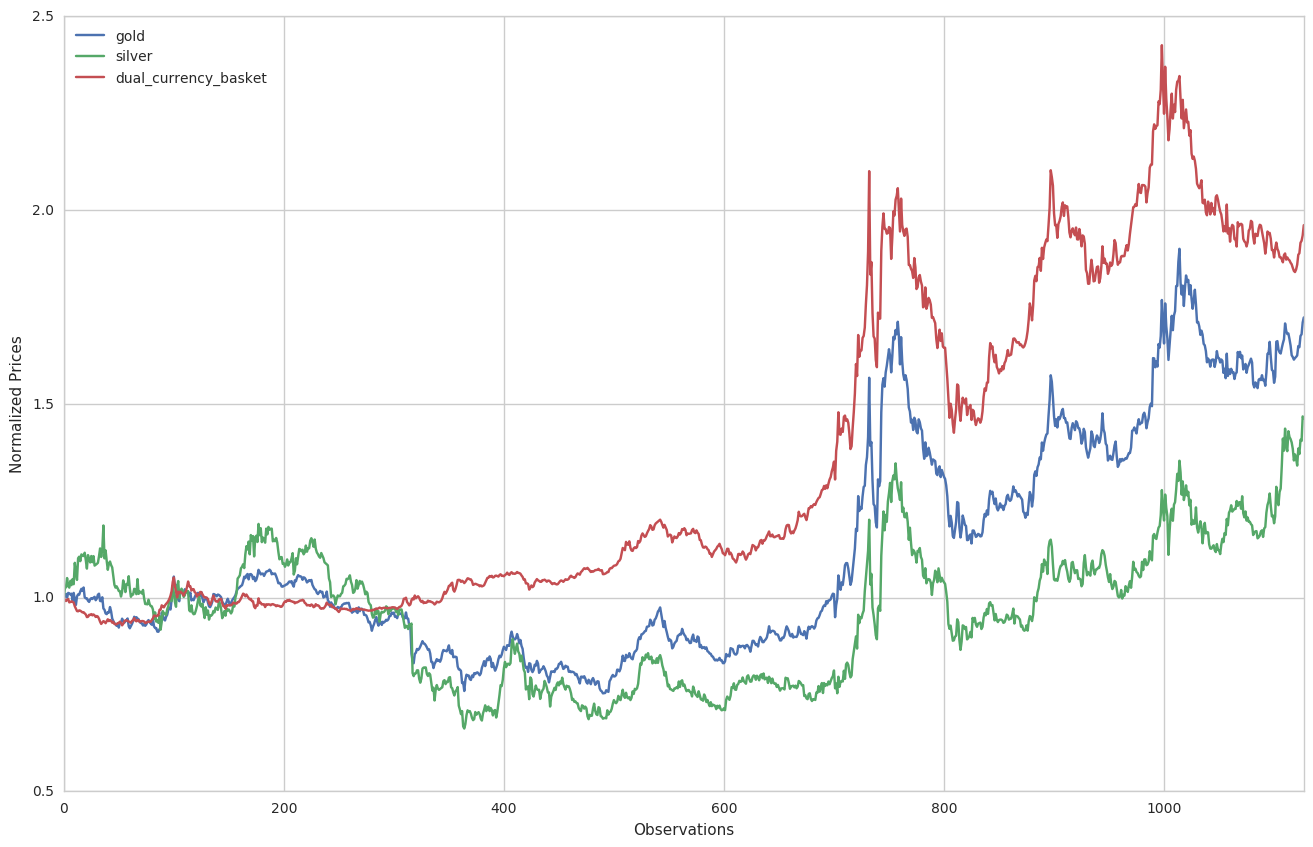

In [9]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,10))
norm_gold.plot()
norm_silver.plot()
norm_dcb.plot()
plt.legend(['gold', 'silver', 'dual_currency_basket'], loc=2)
plt.xlabel("Observations")
plt.ylabel("Normalized Prices")

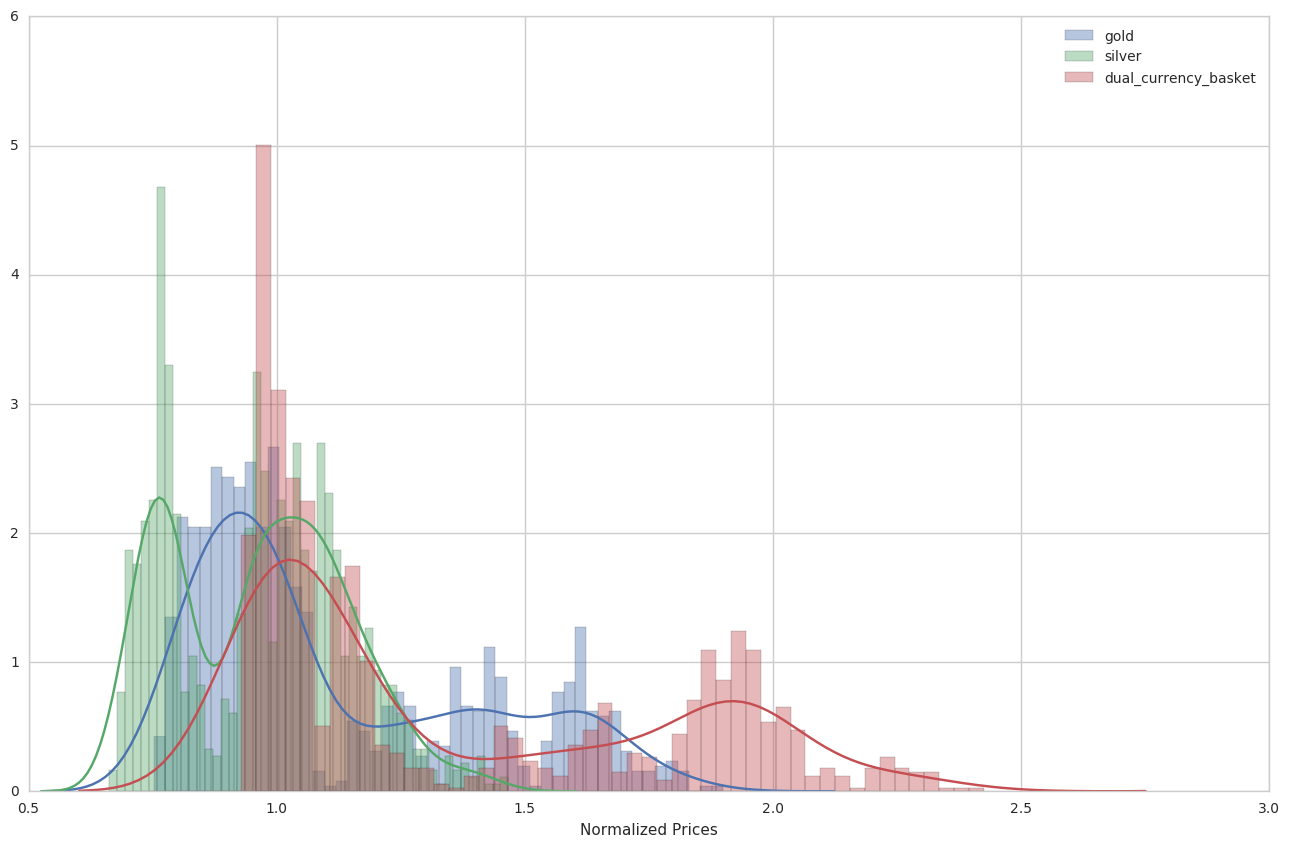

In [10]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,10))
sns.distplot(norm_gold, bins=50)
sns.distplot(norm_silver, bins=50)
sns.distplot(norm_dcb, bins=50)
plt.legend(['gold', 'silver', 'dual_currency_basket'])
plt.xlabel("Normalized Prices")

# Bollinger Bands

In [11]:
rm_norm_gold= norm_gold.rolling(window=20,center=False).mean()
rstd_norm_gold= norm_gold.rolling(window=20,center=False).std()
upper_band_norm_gold, lower_band_norm_gold = rm_norm_gold + 2 * rstd_norm_gold, rm_norm_gold - 2 * rstd_norm_gold

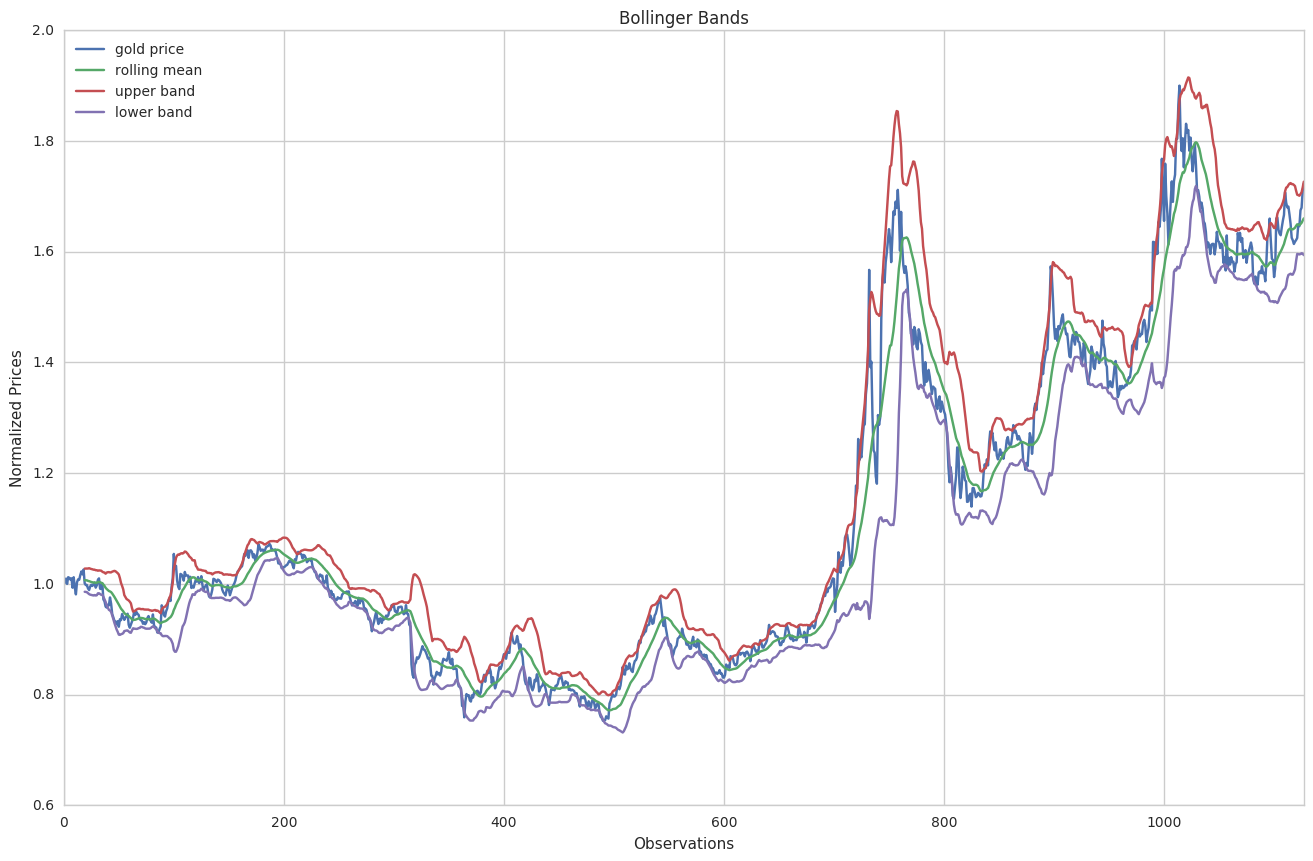

In [12]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,10))
norm_gold.plot(label='gold price')
rm_norm_gold.plot(label='rolling mean')
upper_band_norm_gold.plot(label='upper band')
lower_band_norm_gold.plot(label='lower band')
plt.xlabel("Observations")
plt.ylabel("Normalized Prices")
plt.title('Bollinger Bands')
plt.legend(loc=2)

# Daily Returns

In [13]:
daily_returns = finance_df.copy()
daily_returns[1:] = finance_df[1:] / finance_df[:-1].values - 1
daily_returns.ix[0,:] = 0

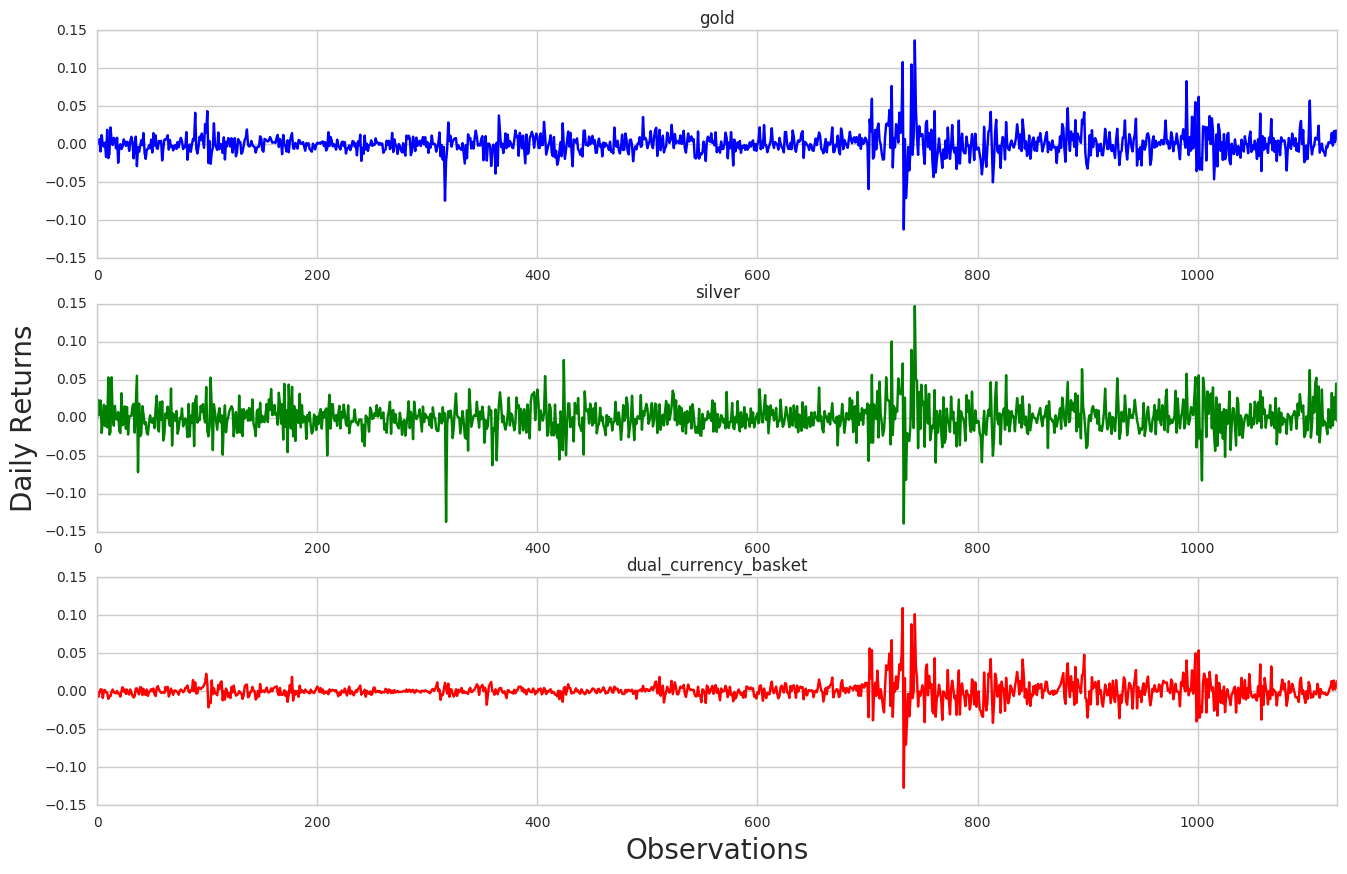

In [14]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,10))
plt.subplot(311)
daily_returns.gold.plot(c='b',title='gold')
plt.subplot(312)
daily_returns.silver.plot(c='g', title='silver')
plt.ylabel("Daily Returns", fontsize=20)
plt.subplot(313)
daily_returns.dual_currency_basket.plot(c='r', title='dual_currency_basket')
plt.xlabel("Observations", fontsize=20)

In [15]:
daily_return_gold = gold.pct_change(1)
monthly_return_gold = gold.pct_change(21)
annual_return_gold = gold.pct_change(252)

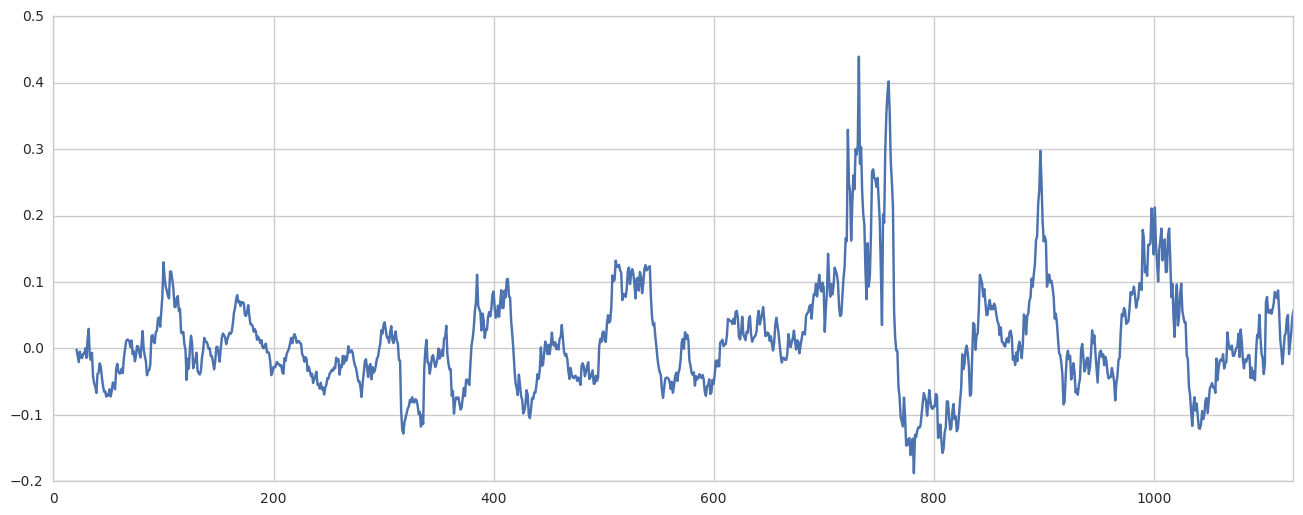

In [16]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,6))
monthly_return_gold.plot()

In [17]:
print "daily returns"
mean_gold = daily_return_gold.mean()
print " mean =", mean_gold
std_gold = daily_return_gold.std()
print " std =", std_gold

daily returns
 mean = 0.000609380882075
 std = 0.0159881852977


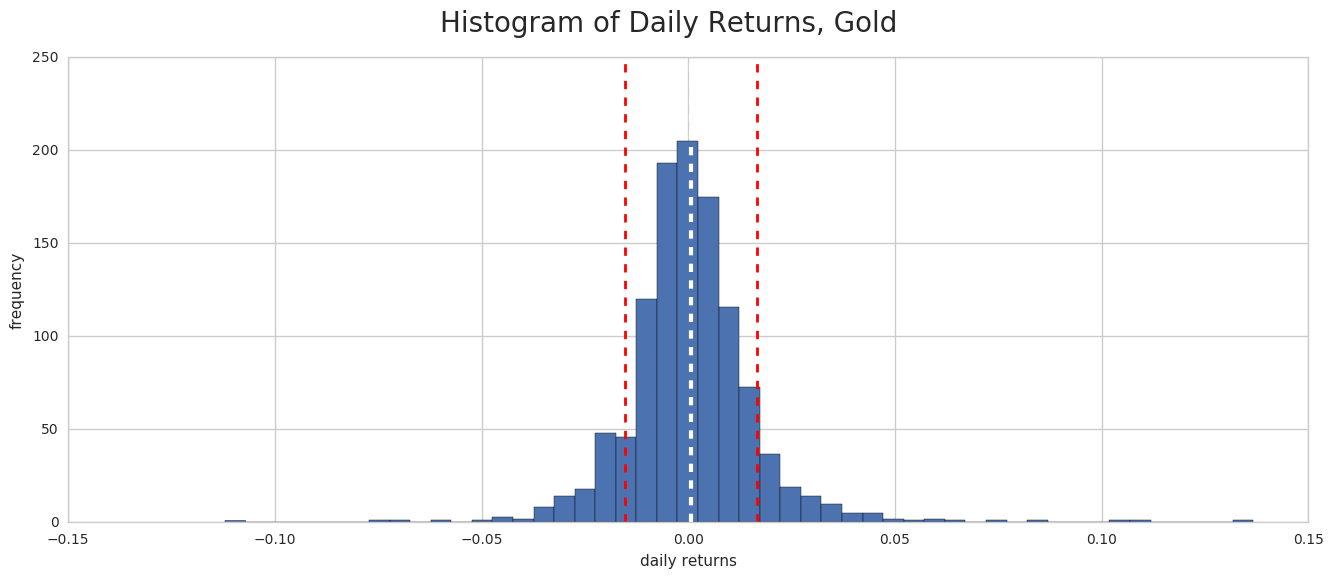

In [18]:
plt.figure(figsize=(16,6))
daily_return_gold.hist(bins=50)
plt.axvline( mean_gold, color='w', linestyle='dashed', linewidth=3)
plt.axvline( mean_gold + std_gold, color ='r', linestyle='dashed', linewidth=2)
plt.axvline( mean_gold - std_gold, color ='r', linestyle='dashed', linewidth=2)
plt.xlabel("daily returns")
plt.ylabel("frequency")
plt.suptitle("Histogram of Daily Returns, Gold", fontsize=20)

# Line Optimazer

Original line: a = 0.699999988079 , b = 0.10000000149
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.1872161745
            Iterations: 3
            Function evaluations: 19
            Gradient evaluations: 3
Fitted line: a = 0.638837500389, b = 0.25366971446


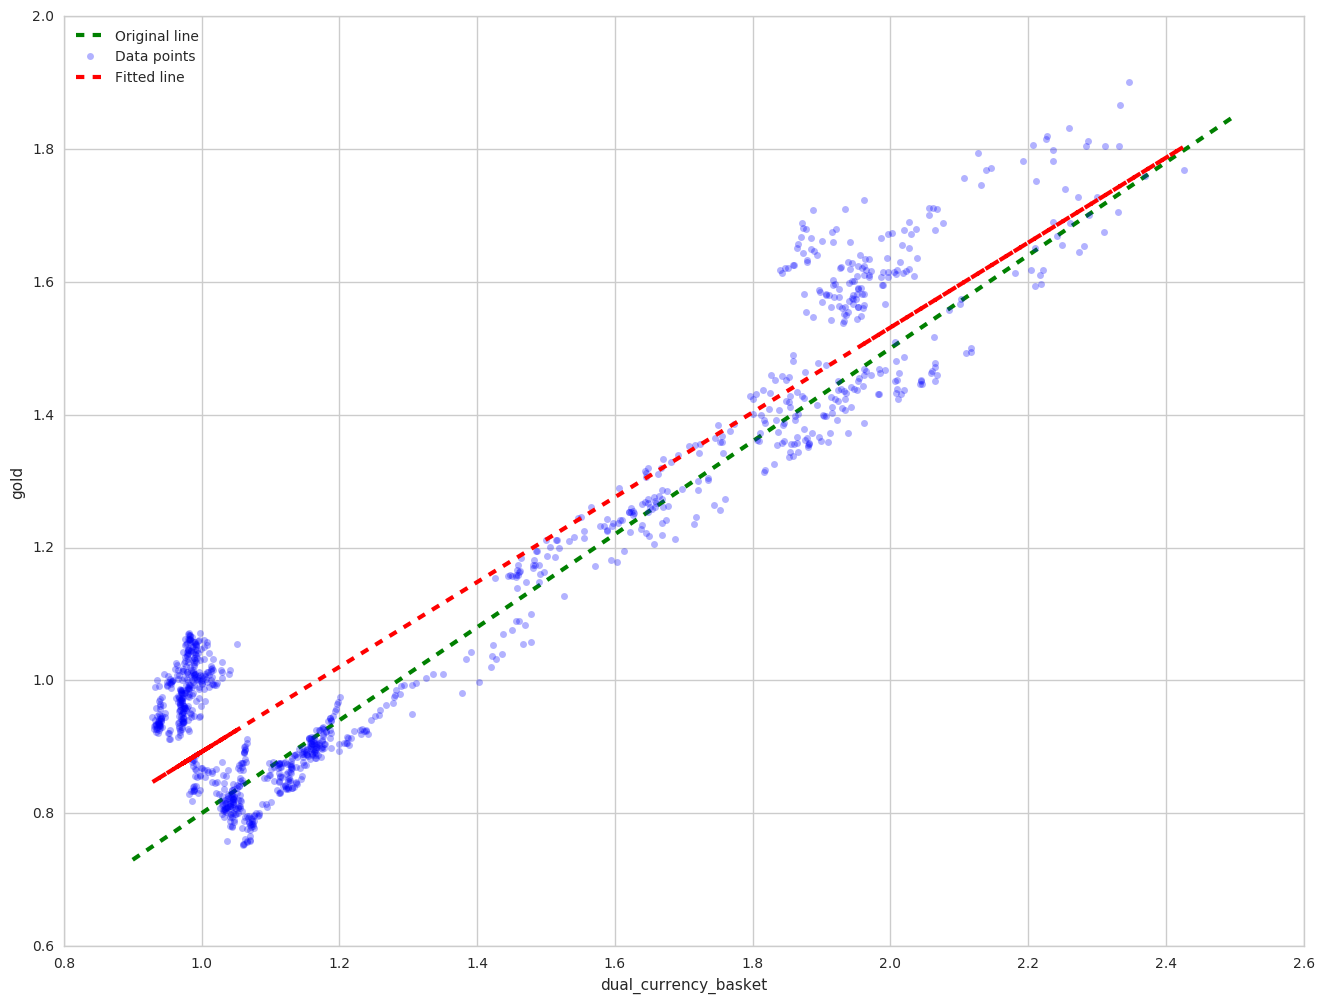

In [19]:
# line as a tuple (a , b): y=ax+b
def error(line, x, y):
    return np.sum((y - (line[0] * x + line[1])) ** 2)
def fit_line(x, y, error_function):
    # initial guess for parameters
    l = np.float32([0, np.mean(y)])
    return spo.minimize(error_function, l, args=(x,y), method='SLSQP', options={'disp': True }).x
def test_run():
    original = np.float32([0.7, 0.1])
    print "Original line: a = {} , b = {}".format(original[0], original[1])
    Xoriginal = np.linspace(0.9, 2.5, 1000)
    Yoriginal = original[0]* Xoriginal + original[1]
    
    plt.figure(figsize=(16, 12))
    plt.plot (Xoriginal, Yoriginal, 'g--', linewidth=3, label="Original line")
    plt.plot (norm_dcb, norm_gold, 'bo', markersize=5, label="Data points", alpha=0.3)

    l_fit = fit_line(norm_dcb, norm_gold, error)
    print "Fitted line: a = {}, b = {}".format(l_fit[0], l_fit[1])
    plt.plot(norm_dcb, l_fit[0] * norm_dcb + l_fit[1], 'r--', linewidth=3, label="Fitted line")
#    plt.title("Line Optimizer")
    plt.xlabel("dual_currency_basket")
    plt.ylabel("gold")
    plt.legend(loc=2)
    plt.show()

test_run()

# Portfolio Statistics

In [20]:
norm_metal.head()

,gold,silver,platinum,palladium
0,1.000000,1.000000,1.000000,1.000000
1,1.002771,1.023342,1.011932,1.006783
2,1.009549,1.027064,1.021905,1.006537
3,1.000036,1.050406,1.007204,0.989332
4,1.012086,1.029432,1.022534,1.013011


In [21]:
norm_weighted_prices = norm_metal * portfolio_metal
norm_weighted_prices.head()

,gold,silver,platinum,palladium
0,0.400000,0.100000,0.300000,0.200000
1,0.401108,0.102334,0.303580,0.201357
2,0.403819,0.102706,0.306572,0.201307
3,0.400014,0.105041,0.302161,0.197866
4,0.404834,0.102943,0.306760,0.202602


In [22]:
portfolio_value = norm_weighted_prices.copy().sum(axis=1)
portfolio_value.head()

0    1.000000
1    1.008379
2    1.014405
3    1.005082
4    1.017140
dtype: float64

In [23]:
portfolio_returns = portfolio_value.copy()
portfolio_returns[1:] = portfolio_value[1:] / portfolio_value[:-1].values - 1
portfolio_returns[0] = 0
portfolio_returns.head()

0    0.000000
1    0.008379
2    0.005976
3   -0.009190
4    0.011996
dtype: float64

In [24]:
portfolio_volatility = np.std(portfolio_returns)
portfolio_volatility

0.014934283287051464

In [25]:
portfolio_avgreturns = np.mean(portfolio_returns)
portfolio_avgreturns

0.00062461769889955992

In [26]:
# for daily risk = 0
portfolio_sharpe_ratio =  np.sqrt(252) * (portfolio_avgreturns / portfolio_volatility)
portfolio_sharpe_ratio

0.66394204422672409

In [27]:
portfolio_cumreturns = (1 + portfolio_returns).cumprod() - 1
portfolio_cumreturns.head()

0    0.000000
1    0.008379
2    0.014405
3    0.005082
4    0.017140
dtype: float64

In [28]:
portfolio_cumreturns.values[-1]

0.78519184610436632

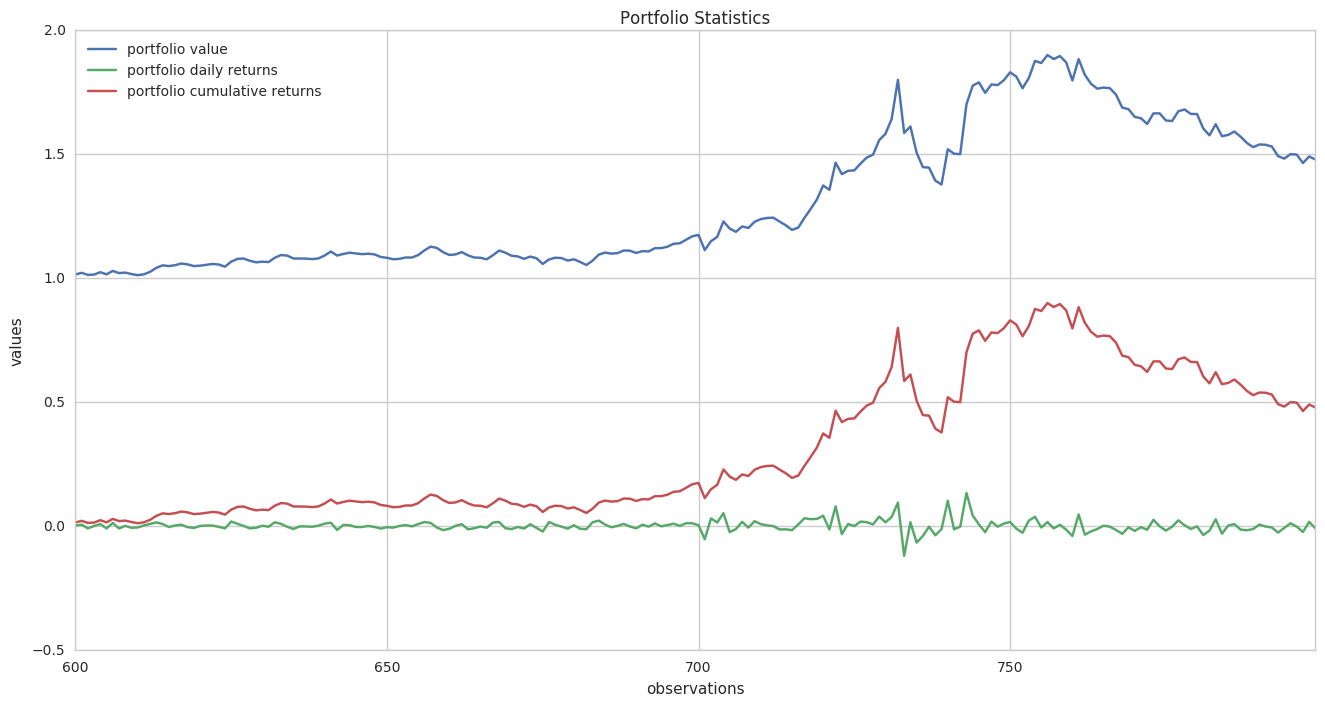

In [29]:
plt.figure(figsize=(16,8))
portfolio_value[600:800].plot(label="portfolio value")
portfolio_returns[600:800].plot(label="portfolio daily returns")
portfolio_cumreturns[600:800].plot(label="portfolio cumulative returns")
plt.title("Portfolio Statistics")
plt.xlabel("observations")
plt.ylabel("values")
plt.legend(loc=2)

In [30]:
def calcStats(normalized_price, allocations):
    # row-wise multiplication by weights
    weighted_price = normalized_price * allocations
    # row-wise sum
    portfolio_value = weighted_price.copy().sum(axis=1)

    # calculate daily returns on portfolio
    portfolio_returns = portfolio_value.copy()
    portfolio_returns[1:] = portfolio_value[1:] / portfolio_value[:-1].values - 1
    portfolio_returns[0] = 0

    # calculate volatility (std) of daily returns of portfolio
    portfolio_volatility = np.std(portfolio_returns) 

    #Calculate average daily returns of portfolio
    portfolio_avgreturns = np.mean(portfolio_returns)

    #Calculate portfolio sharpe ratio (avg portfolio return / portfolio std) * sqrt(252)
    portfolio_sharpe_ratio = (portfolio_avgreturns / portfolio_volatility) * np.sqrt(252)

    # calculate cumulative daily return
    portfolio_cumreturns = (1 + portfolio_returns).cumprod() - 1

    return [portfolio_volatility, portfolio_avgreturns, portfolio_sharpe_ratio, 
            portfolio_cumreturns.values[-1], portfolio_value.values[-1]]

In [31]:
print 'portfolio volatility, portfolio average returns, portfolio sharpe ratio, portfolio cumulative returns, portfolio value'
print calcStats(norm_metal, portfolio_metal)

portfolio volatility, portfolio average returns, portfolio sharpe ratio, portfolio cumulative returns, portfolio value
[0.014934283287051464, 0.00062461769889955992, 0.66394204422672409, 0.78519184610436632, 1.785191846104373]


In [32]:
print calcStats(norm_metal[:252], portfolio_metal)

[0.0086576095771857872, 9.9361325562044445e-05, 0.18218795040213442, 0.015721106555692366, 1.0157211065556921]


In [33]:
print calcStats(norm_metal[:504], portfolio_metal)

[0.0093990327997796053, -2.3464472431512718e-05, -0.039630349220976933, -0.033542935479022762, 0.96645706452097846]


In [34]:
print calcStats(norm_metal[:756], portfolio_metal)

[0.014137157187837987, 0.00092584750719994148, 1.0396272277968819, 0.86815117472075487, 1.8681511747207593]


In [35]:
print calcStats(norm_metal[:1008], portfolio_metal)

[0.015019143966330081, 0.00060632633909446238, 0.64085757890933248, 0.64581756501250043, 1.6458175650125062]


# Portfolio Value Optimizer

In [91]:
norm_metal.head()

,gold,silver,platinum,palladium
0,1.000000,1.000000,1.000000,1.000000
1,1.002771,1.023342,1.011932,1.006783
2,1.009549,1.027064,1.021905,1.006537
3,1.000036,1.050406,1.007204,0.989332
4,1.012086,1.029432,1.022534,1.013011


In [90]:
# fixed allocations
portfolio_metal

[0.4, 0.1, 0.3, 0.2]

In [37]:
k1, k2, k3, k4 = np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), np.arange(0, 1, 0.01)

In [38]:
setsum1 = []
for el1 in k1:
    for el2 in k2:
        for el3 in k3:
            for el4 in k4:
                if el1 + el2 + el3 + el4 == 1:
                    setsum1.append([round(el1,2), round(el2, 2), round(el3, 2), round(el4, 2)])

In [39]:
setsum1[:5]

[[0.0, 0.0, 0.01, 0.99],
 [0.0, 0.0, 0.02, 0.98],
 [0.0, 0.0, 0.03, 0.97],
 [0.0, 0.0, 0.04, 0.96],
 [0.0, 0.0, 0.05, 0.95]]

In [40]:
len(setsum1)

166998

In [67]:
norm_metal.values[200]

array([ 1.0302894 ,  1.08863329,  1.06260493,  0.94544137])

In [84]:
allocations = []
portfolio_values = []
for i in range(200):
    params = norm_metal.values[i]
    vs=[]
    for element in setsum1:
        v = params * element      
        vs.append(sum(v))

    portfolio_values.append(np.amax(vs)) 
    allocations.append(setsum1[np.argmax(vs)])

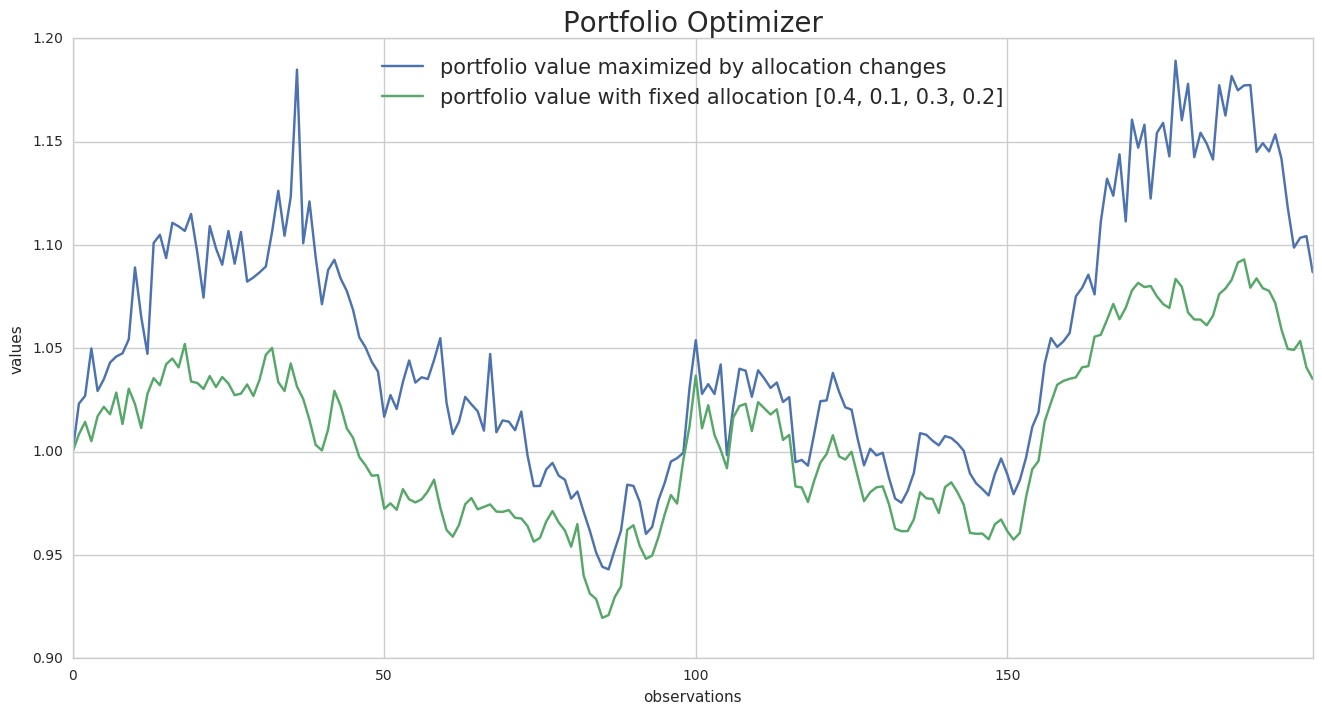

In [99]:
plt.figure(figsize=(16,8))
pd.Series(portfolio_values).plot(label='portfolio value maximized by allocation changes')
portfolio_value[:200].plot(label='portfolio value with fixed allocation [0.4, 0.1, 0.3, 0.2]')
plt.title("Portfolio Optimizer", fontsize=20)
plt.xlabel("observations")
plt.ylabel("values")
plt.legend(loc=9, fontsize=15)